In [1]:
# import all necessary libraries
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cosine
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import tensorflow as tf
import warnings
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import KFold
warnings.filterwarnings("ignore")

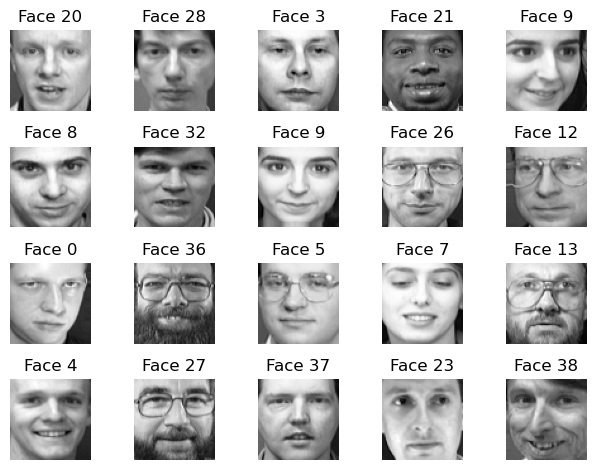

In [2]:
# 1. Retrieve and load the Olivetti faces dataset

# Fetch the Olivetti faces dataset
data = fetch_olivetti_faces(shuffle=True, random_state=42)
faces = data.images
X = data.data
y = data.target

# Display the first few images as an example
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(faces[i], cmap='gray')
    plt.title(f"Face {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [3]:
# 2. Split the training set, a validation set, and a test set using stratified sampling to ensure 
# that there are the same number of images per person in each set.

# Split the dataset into a temporary training set and a test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split the temporary training set into a final training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Training set size: 240
Validation set size: 80
Test set size: 80


In [4]:
# 7. Determine most suitable covariance_type

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X)

print(f"Original number of features: {X.shape[1]}")
print(f"Reduced number of features: {X_pca.shape[1]}")



Original number of features: 4096
Reduced number of features: 260


In [5]:
# 10. Autoencoder Model Definition
def create_autoencoder(input_dim, encoding_dim1, central_dim, encoding_dim2, regularization):
    # Input
    input_layer = Input(shape=(input_dim,))

    # Encoding layers
    encoded1 = Dense(encoding_dim1, activation='relu', activity_regularizer=l1(regularization))(input_layer)
    central = Dense(central_dim, activation='relu')(encoded1)

    # Decoding layers
    decoded1 = Dense(encoding_dim2, activation='relu')(central)
    decoded2 = Dense(input_dim, activation='relu')(decoded1)

    # Autoencoder model
    autoencoder = Model(input_layer, decoded2)
    return autoencoder

In [6]:
# # Define the model
# autoencoder = create_autoencoder(X_pca.shape[1], 512, 256, 128, 1e-5)

# # Compile the model
# autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# # Early stopping and model checkpoint callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_autoencoder.h5', monitor='val_loss', save_best_only=True)

# # Train the model with a validation split
# autoencoder.fit(X_pca, X_pca, 
#                 epochs=200, 
#                 batch_size=32, 
#                 shuffle=True, 
#                 validation_split=0.1,  # Using part of training data as validation
#                 callbacks=[early_stopping, model_checkpoint], 
#                 verbose=0)

# # Load the best model
# autoencoder.load_weights('best_autoencoder.h5')

In [7]:
# 11. K-Fold Cross-Validation for Autoencoder Model Tuning

def cross_validate_autoencoder(X, learning_rate, regularization, encoding_dim1, central_dim, encoding_dim2, k=5, epochs=10, batch_size=32):
    fold_performance = []

    kf = KFold(n_splits=k, shuffle=True)
    for train_index, test_index in kf.split(X):
        # Split data
        X_train, X_val = X[train_index], X[test_index]

        # Create and compile the model
        autoencoder = create_autoencoder(X.shape[1], encoding_dim1, central_dim, encoding_dim2, regularization)
        autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

        # Train the model
        history = autoencoder.fit(X_train, X_train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  validation_data=(X_val, X_val),
                                  verbose=0)

        # Store the performance
        fold_performance.append(history.history['val_loss'][-1])

    return np.mean(fold_performance), np.std(fold_performance)

In [8]:
# 1. Hyperparameter Optimization for Autoencoder Using Grid Search

learning_rates = [0.001, 0.0001]
regularizations = [0.0001, 0.00001]
layer_sizes = [(128, 64, 128), (256, 128, 256), (512, 256, 128)]

best_score = float('inf')
best_params = {}

# Iterate over all combinations of hyperparameters
for lr in learning_rates:
    for reg in regularizations:
        for sizes in layer_sizes:
            encoding_dim1, central_dim, encoding_dim2 = sizes
            mean_score, std_score = cross_validate_autoencoder(
                X_pca,
                learning_rate=lr,
                regularization=reg,
                encoding_dim1=encoding_dim1,
                central_dim=central_dim,
                encoding_dim2=encoding_dim2,
                epochs=20,
                batch_size=32
            )

            # If the current mean_score is better than the best_score, update best_score and best_params
            if mean_score < best_score:
                best_score = mean_score
                best_params = {
                    'lr': lr,
                    'reg': reg,
                    'sizes': sizes
                }

print("Best parameters:", best_params)

Best parameters: {'lr': 0.001, 'reg': 1e-05, 'sizes': (512, 256, 128)}


ReLU is chosen for the hidden layers because it introduces non-linearity to the model without affecting the scale of the input, which is particularly beneficial for deep networks. It helps with gradient propagation since the gradient is either 0 (for negative inputs) or 1 (for positive inputs), reducing the risk of vanishing gradients during backpropagation. ReLU is computationally efficient as it involves simpler mathematical operations compared to other functions like sigmoid or tanh.

The sigmoid function is used in the output layer because it squashes the output to be within the range of 0 to 1. This is particularly useful if the autoencoder is meant to reconstruct input data that has been normalized to be within this range.

Mean Squared Error (MSE) Loss Function: MSE is a common choice for regression problems, and an autoencoder can be considered a regression problem since it aims to output a value (the reconstructed input) that is as close as possible to the input value.
It is suitable for models where the output activation function is linear or sigmoid, and the range of values is continuous.
MSE penalizes larger errors more than smaller ones, which can lead to better model performance when it is important to minimize large reconstruction errors. For autoencoders, especially when dealing with normalized inputs, it ensures that the model is penalized based on the squared difference between each pixel of the input and its reconstruction, emphasizing a precise reconstruction of the input data.

3/3 [==============================] - 0s 4ms/step


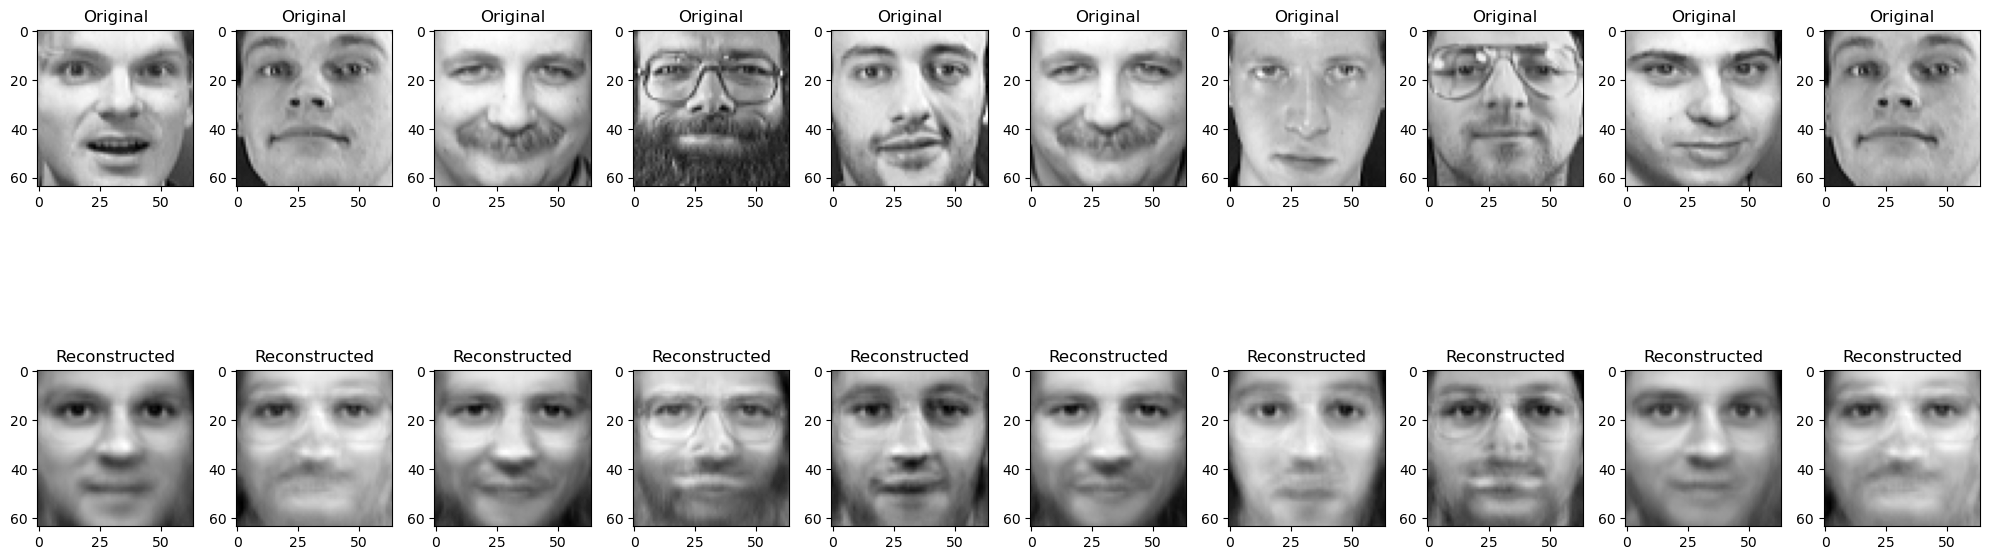

In [9]:
# 13. Training and Visual Evaluation of an Optimized Autoencoder Model

# Define and train the best autoencoder model with the best parameters
best_lr = best_params['lr']
best_reg = best_params['reg']
best_sizes = best_params['sizes']

autoencoder = create_autoencoder(X_pca.shape[1], best_sizes[0], best_sizes[1], best_sizes[2], best_reg)
autoencoder.compile(optimizer=Adam(learning_rate=best_lr), loss='mean_squared_error')
autoencoder.fit(X_pca, X_pca, epochs=100, batch_size=32, shuffle=True, verbose=0)

X_test_pca = pca.transform(X_test[:, :4096])
X_test_pred = autoencoder.predict(X_test_pca)

# Number of images to display
num_images = 10

# Randomly select some images for display
random_indices = np.random.choice(len(X_test), num_images)

# Create subplots for original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(20, 8))

for i, idx in enumerate(random_indices):
    # Original image (use only the first 4096 features)
    original_img = X_test[idx][:4096].reshape(64, 64)
    axes[0, i].imshow(original_img, cmap='gray')
    axes[0, i].set_title("Original")

    # Reconstructed image
    reconstructed_img_pca = pca.inverse_transform(X_test_pred[idx])
    reconstructed_img_pca = reconstructed_img_pca.reshape(64, 64)
    axes[1, i].imshow(reconstructed_img_pca, cmap='gray')
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()